In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
from scipy.stats import norm

In [ ]:
x = torch.rand(200)*2-1
y = -torch.sqrt(1 - x**2)
smile = torch.cat([x.reshape(-1,1),y.reshape(-1,1)], dim = 1)

mean_eye_left = torch.Tensor([-0.6, 0.8])
mean_eye_right = torch.Tensor([0.6, 0.8])

eye_left_x = torch.normal(mean_eye_left[0], 0.02, size = (100,1))
eye_left_y = torch.normal(mean_eye_left[1], 0.02, size = (100,1))
eye_left = torch.cat([eye_left_x, eye_left_y], dim = 1)

eye_right_x = torch.normal(mean_eye_right[0], 0.02, size = (100,1))
eye_right_y = torch.normal(mean_eye_right[1], 0.02, size = (100,1))
eye_right = torch.cat([eye_right_x, eye_right_y], dim = 1)

Data = torch.cat([smile, eye_left, eye_right], dim = 0)

In [ ]:
x = torch.rand(200)*2-1
y = -torch.sqrt(1 - x**2)
smile = torch.cat([x.reshape(-1,1),y.reshape(-1,1)], dim = 1)

mean_eye_left = torch.Tensor([-0.6, 0.8])
mean_eye_right = torch.Tensor([0.6, 0.8])

eye_left_x = torch.normal(mean_eye_left[0], 0.02, size = (100,1))
eye_left_y = torch.normal(mean_eye_left[1], 0.02, size = (100,1))
eye_left = torch.cat([eye_left_x, eye_left_y], dim = 1)

eye_right_x = torch.normal(mean_eye_right[0], 0.02, size = (100,1))
eye_right_y = torch.normal(mean_eye_right[1], 0.02, size = (100,1))
eye_right = torch.cat([eye_right_x, eye_right_y], dim = 1)

Data_val = torch.cat([smile, eye_left, eye_right], dim = 0)

In [ ]:
"""mean_eye_left = torch.Tensor([-6, 0])
mean_eye_right = torch.Tensor([6, 0])

eye_left_x = torch.normal(mean_eye_left[0], 1, size = (100,1))
eye_left_y = torch.normal(mean_eye_left[1], 1, size = (100,1))
eye_left = torch.cat([eye_left_x, eye_left_y], dim = 1)

eye_right_x = torch.normal(mean_eye_right[0], 1, size = (100,1))
eye_right_y = torch.normal(mean_eye_right[1], 1, size = (100,1))
eye_right = torch.cat([eye_right_x, eye_right_y], dim = 1)

Data = torch.cat([eye_left, eye_right], dim = 0)"""

'mean_eye_left = torch.Tensor([-6, 0])\nmean_eye_right = torch.Tensor([6, 0])\n\neye_left_x = torch.normal(mean_eye_left[0], 1, size = (100,1))\neye_left_y = torch.normal(mean_eye_left[1], 1, size = (100,1))\neye_left = torch.cat([eye_left_x, eye_left_y], dim = 1)\n\neye_right_x = torch.normal(mean_eye_right[0], 1, size = (100,1))\neye_right_y = torch.normal(mean_eye_right[1], 1, size = (100,1))\neye_right = torch.cat([eye_right_x, eye_right_y], dim = 1)\n\nData = torch.cat([eye_left, eye_right], dim = 0)'

In [ ]:
Data.shape

torch.Size([400, 2])

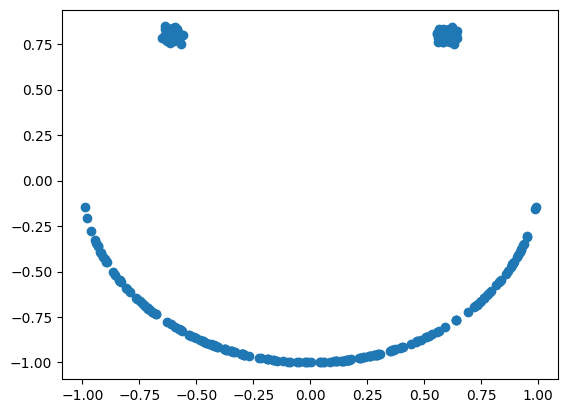

In [ ]:
plt.scatter(x = Data_val.cpu().numpy()[:,0], y = Data_val.cpu().numpy()[:,1])

In [ ]:
def sigma2(t, b_min = 0.1, b_max = 20.0):
  return 1.0 -  torch.exp(-(t*b_min + (t**2)/2*(b_max-b_min)))

def mu(t, b_min = 0.1, b_max = 20.0):
  return torch.exp(-1/2*(t*b_min + (t**2)/2*(b_max-b_min)))

In [ ]:
def sample(t, x0, M, b_min = 0.1, b_max = 20.0):
  ''''
    x_0: A matrix (n, d)
    t: A vector with size (k)

    return sample of size (n*k*m, d+1)
  '''

  mean = mu(t)
  var = sigma2(t)
  samples = torch.zeros((x0.shape[0]*t.shape[0]*M, x0.shape[1] + 1)).to(device)
  c = 0
  N = x0.shape[0]
  d = x0.shape[1]
  for j in range(t.shape[0]):
    for l in range(M):
      sample_aux = torch.normal(x0*mean[j], std = torch.sqrt(var[j])).to(device)
      samples[c*N:(c+1)*N, 0:d] = sample_aux
      samples[c*N:(c+1)*N, d] = t[j]*torch.ones(N).to(device)
      c += 1
  return samples

def loss_fn(model, x, b_min = 0.1, b_max = 20.0, M = 30, eps=1e-4, T = 1.0, N = 20):
  step = (T-eps)/N
  t = torch.arange(eps, T, step)
  t = torch.concatenate((t, torch.tensor([1.0]))).to(device)
  samples = sample(t, x, M, b_min = b_min, b_max = b_max)
  t = samples[:, -1].reshape(-1,1)
  x = x.repeat(samples.shape[0]//x.shape[0] ,1)
  mean = x * mu(t, b_min = b_min, b_max = b_max)
  var =  sigma2(t, b_min = b_min, b_max = b_max)
  score_match = -(samples[:, :-1] - mean) / var
  score = model(samples)
  loss = torch.mean(var*(score - score_match)**2)
  return loss

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 2),
        )

    def forward(self, x):
        logits = self.net(x)
        return logits

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

<Axes: ylabel='Density'>

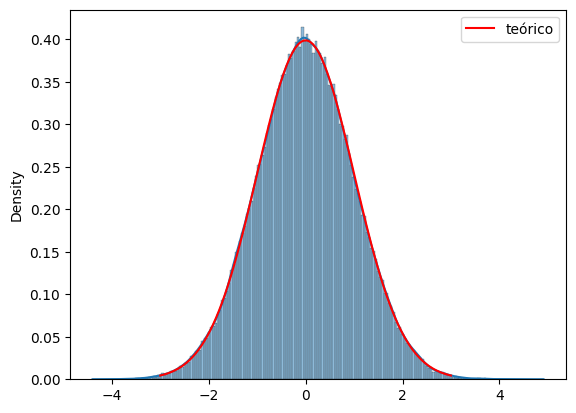

In [ ]:
Noisex = sample(torch.ones(500,1).to(device), Data.to(device), 1)[:,0]
sns.histplot(Noisex.cpu().numpy(), stat='density', kde = True)
#y = np.array(1/2*norm.pdf(x,-3,1)) + np.array(1/2*norm.pdf(x,3,1))
x = np.linspace(-3, 3, 100)
y = np.array(norm.pdf(x,0,1))
sns.lineplot(x=x, y=y, color='red', label='teórico')

<Axes: ylabel='Density'>

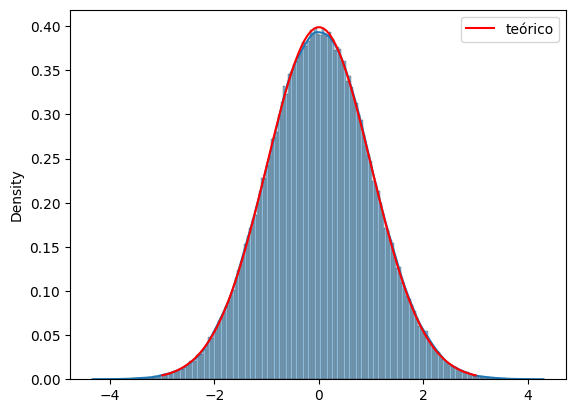

In [ ]:
Noisey = sample(torch.ones(500,1).to(device), Data.to(device), 1)[:,1]
sns.histplot(Noisey.cpu().numpy(), stat='density', kde = True)
#y = np.array(1/2*norm.pdf(x,-3,1)) + np.array(1/2*norm.pdf(x,3,1))
x = np.linspace(-3, 3, 100)
y = np.array(norm.pdf(x,0,1))
sns.lineplot(x=x, y=y, color='red', label='teórico')

In [ ]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = NeuralNetwork()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Data = Data.to(device)
Data_val = Data_val.to(device)
model = model.to(device)
lr = 1e-4
batch_size = 64
optimizer = Adam(model.parameters(), lr = lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
data_loader = DataLoader(Data, batch_size=batch_size, shuffle=True)
loss_plot = []
loss_plot_val = []

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ler modelo salvo
model.load_state_dict(torch.load('/content/drive/MyDrive/TCC/smilev2/smilev3/model_diffusion_smile.pth'))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
# treino
n_epochs = 1000
for epoch in tqdm(range(n_epochs), desc="Training Epochs"):
  avg_loss = 0.
  avg_loss_val = 0.
  num_items = 0
  num_items_val = 0
  for x in data_loader:
    optimizer.zero_grad()
    loss = loss_fn(model, x, M = 10, N = 100, eps = 1e-6)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  with torch.no_grad():
    val_loss = loss_fn(model, Data_val, M = 10, N = 50, eps = 1e-6)
    avg_loss_val += val_loss.item() * Data_val.shape[0]
    num_items_val += Data_val.shape[0]
  if epoch % 50 == 0:
    tqdm.write(f'epoch: {epoch}')
    tqdm.write(f'Average Loss: {avg_loss / num_items:.5f}')
    tqdm.write(f'Average Loss Val: {avg_loss_val / num_items_val:.5f}')
    loss_plot.append(avg_loss / num_items)
    loss_plot_val.append(avg_loss_val / num_items_val)
    scheduler.step(avg_loss_val / num_items_val)
  if epoch % 100 == 0:
    torch.save(model.state_dict(), '/content/drive/MyDrive/TCC/smilev2/smilev3/model_diffusion_smile.pth')

Training Epochs:   0%|          | 1/1000 [00:02<45:21,  2.72s/it]

epoch: 0
Average Loss: 0.14789
Average Loss Val: 0.15070


Training Epochs:   5%|▌         | 51/1000 [01:35<27:52,  1.76s/it]

epoch: 50
Average Loss: 0.14666
Average Loss Val: 0.15207


Training Epochs:  10%|█         | 101/1000 [03:07<26:45,  1.79s/it]

epoch: 100
Average Loss: 0.14774
Average Loss Val: 0.15164


Training Epochs:  15%|█▌        | 151/1000 [04:39<25:53,  1.83s/it]

epoch: 150
Average Loss: 0.14700
Average Loss Val: 0.15148


Training Epochs:  20%|██        | 201/1000 [06:12<25:31,  1.92s/it]

epoch: 200
Average Loss: 0.14746
Average Loss Val: 0.15147


Training Epochs:  25%|██▌       | 251/1000 [07:45<25:04,  2.01s/it]

epoch: 250
Average Loss: 0.14802
Average Loss Val: 0.15188


Training Epochs:  30%|███       | 301/1000 [09:17<21:26,  1.84s/it]

epoch: 300
Average Loss: 0.14658
Average Loss Val: 0.15252


Training Epochs:  35%|███▌      | 351/1000 [10:49<19:07,  1.77s/it]

epoch: 350
Average Loss: 0.14697
Average Loss Val: 0.15225


Training Epochs:  40%|████      | 401/1000 [12:22<18:05,  1.81s/it]

epoch: 400
Average Loss: 0.14734
Average Loss Val: 0.15242


Training Epochs:  45%|████▌     | 451/1000 [13:54<16:57,  1.85s/it]

epoch: 450
Average Loss: 0.14830
Average Loss Val: 0.15001


Training Epochs:  50%|█████     | 501/1000 [15:27<16:10,  1.94s/it]

epoch: 500
Average Loss: 0.14738
Average Loss Val: 0.15204


Training Epochs:  55%|█████▌    | 551/1000 [16:59<14:22,  1.92s/it]

epoch: 550
Average Loss: 0.14812
Average Loss Val: 0.15363


Training Epochs:  60%|██████    | 601/1000 [18:31<11:47,  1.77s/it]

epoch: 600
Average Loss: 0.14738
Average Loss Val: 0.15306


Training Epochs:  65%|██████▌   | 651/1000 [20:04<10:19,  1.77s/it]

epoch: 650
Average Loss: 0.14705
Average Loss Val: 0.15374


Training Epochs:  70%|███████   | 701/1000 [21:36<09:04,  1.82s/it]

epoch: 700
Average Loss: 0.14716
Average Loss Val: 0.15197


Training Epochs:  75%|███████▌  | 751/1000 [23:08<07:54,  1.91s/it]

epoch: 750
Average Loss: 0.14826
Average Loss Val: 0.15346


Training Epochs:  80%|████████  | 801/1000 [24:40<06:42,  2.02s/it]

epoch: 800
Average Loss: 0.14708
Average Loss Val: 0.15268


Training Epochs:  85%|████████▌ | 851/1000 [26:12<04:29,  1.81s/it]

epoch: 850
Average Loss: 0.14761
Average Loss Val: 0.15408


Training Epochs:  90%|█████████ | 901/1000 [27:44<02:57,  1.79s/it]

epoch: 900
Average Loss: 0.14743
Average Loss Val: 0.15302


Training Epochs:  95%|█████████▌| 951/1000 [29:17<01:28,  1.81s/it]

epoch: 950
Average Loss: 0.14776
Average Loss Val: 0.15346


Training Epochs: 100%|██████████| 1000/1000 [30:48<00:00,  1.85s/it]


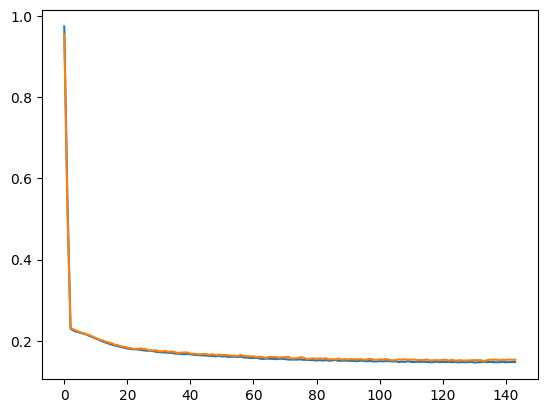

In [ ]:
plt.plot(loss_plot)
plt.plot(loss_plot_val)

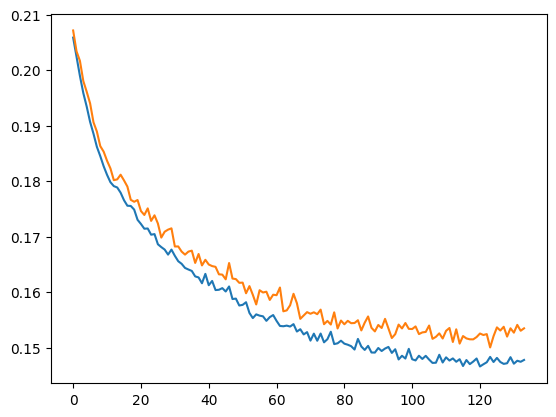

In [ ]:
plt.plot(loss_plot[10:])
plt.plot(loss_plot_val[10:])

In [ ]:
def generate(model, N, d = 100, T = 1, b_min = 0.1, b_max = 20):
  X = torch.randn((d,2)).to(device)
  dt = T/N
  eps = 1e-5
  T = T - eps
  def beta(t):
    return b_min + (b_max - b_min)*t
  for i in range(N):
    t = i*T/N
    W = torch.randn((d,2)).to(device)
    xt = torch.cat((X, (1-t)*torch.ones((d,1)).to(device)), dim = 1).to(device)
    X = X - (-1/2*beta(T-t)*X - beta(T-t)*model(xt))*dt + np.sqrt(beta(T-t)*dt) * W
  return X

In [40]:
#del sample_new
import gc
gc.collect() # Run garbage collection to free up memory
torch.cuda.empty_cache() # Empty CUDA cache

In [ ]:
sample_new = generate(model, 10000, d = 300)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

In [ ]:
plt.scatter(sample_new.detach().cpu().numpy()[:,0], sample_new.detach().cpu().numpy()[:,1])

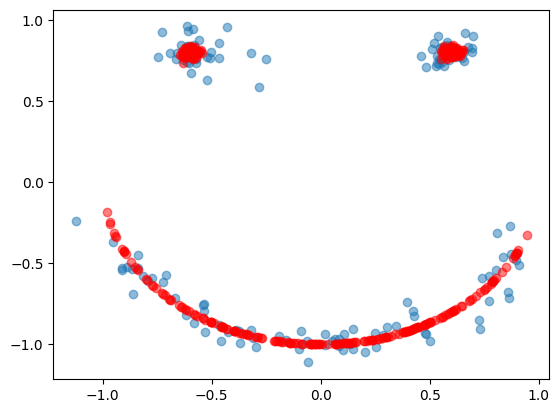

In [ ]:
plt.scatter(sample_new.detach().cpu().numpy()[:,0], sample_new.detach().cpu().numpy()[:,1], alpha = 0.5)
plt.scatter(x = Data.cpu().numpy()[:,0], y = Data.cpu().numpy()[:,1], color = 'red', alpha = 0.5)

In [ ]:
#del sample_new
import gc
gc.collect() # Run garbage collection to free up memory
torch.cuda.empty_cache() # Empty CUDA cache

In [41]:
from scipy.integrate import solve_ivp
def function_flow(t, x):
  def beta(t):
    b_min = 0.1
    b_max = 20.
    return b_min + (b_max - b_min)*t
  T = 1
  f = -beta(T-t)*x/2
  g2 = beta(T-t)
  model.eval()
  with torch.no_grad():
    xpt = torch.tensor([x]).to(device).float()
    tpt = torch.tensor([T-t]).to(device).float().reshape((1,1))
    xt = torch.cat((xpt, tpt), dim = 1)
    score = model(xt)
  score = score.detach().cpu().numpy()
  out = f - (g2)*score/2
  return -out

def generate_by_flow_ODE(model, eps = 0, T = 1, b_min = 0.1, b_max = 20):
  model = model
  X = np.random.randn(2)
  sol = solve_ivp(function_flow, [0, T - eps], X, first_step = 1e-4, atol = 1e-5, rtol = 1e-5)
  return sol.y.T[-1,:]

In [49]:
genereate_x = []
genereate_y = []
for i in range(300):
    sample_new = generate_by_flow_ODE(model, eps = 0)
    genereate_x.append(sample_new[0])
    genereate_y.append(sample_new[1])

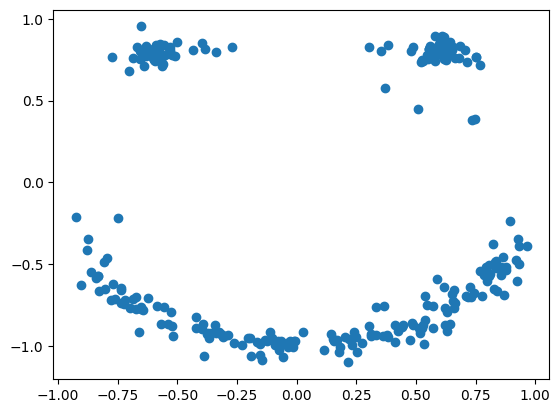

In [51]:
plt.scatter(genereate_x, genereate_y)

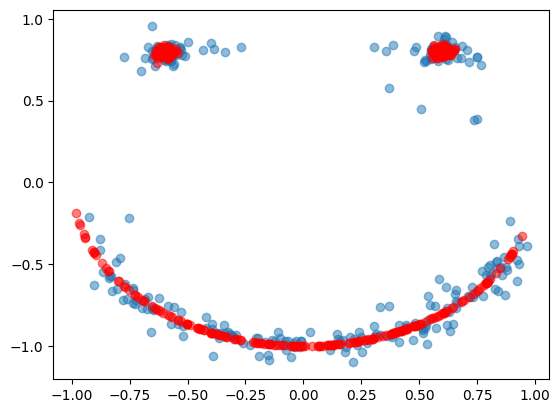

In [52]:
plt.scatter(genereate_x, genereate_y, alpha = 0.5)
plt.scatter(x = Data.cpu().numpy()[:,0], y = Data.cpu().numpy()[:,1], color = 'red', alpha = 0.5)

<Axes: >

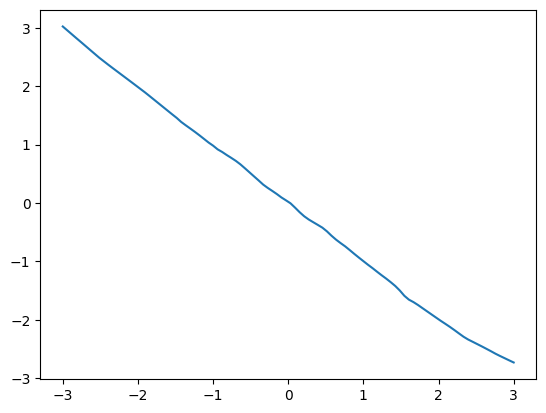

In [ ]:
x = torch.linspace(-3, 3, 100)
x = torch.reshape(x, (100,1))
y = x
t = torch.ones((100, 1))
xt = torch.cat((x,y,t), dim = 1).to(device)
score = model(xt).detach().cpu().numpy()
sns.lineplot(x = x.numpy()[:,0], y = score[:,1])

In [ ]:
del sample_new

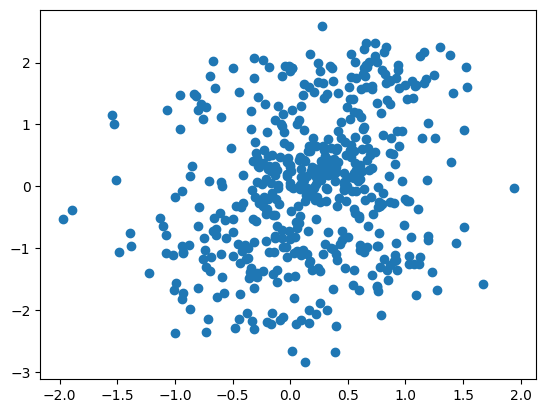

In [ ]:
### amostrar por Langevin
X = torch.randn((500, 2))
N = 1000
T = 100
t = 1e-4*torch.ones((500, 1))
dt = T/N
for i in range(N):
  xt = torch.cat((X,t), dim = 1).to(device)
  W = torch.randn_like(X)
  X = X + model(xt).detach().cpu()/2*dt + np.sqrt(dt)*W
plt.scatter(X.detach().numpy()[:,0], X.detach().cpu().numpy()[:,1])

In [ ]:
caminho_arquivo = 'model_diffusion_smile.pth'
torch.save(model.state_dict(), caminho_arquivo)

In [ ]:
caminho_arquivo = 'model_diffusion_smile.pth'
modelo_carregado = NeuralNetwork()
modelo_carregado.load_state_dict(torch.load(caminho_arquivo))

<All keys matched successfully>

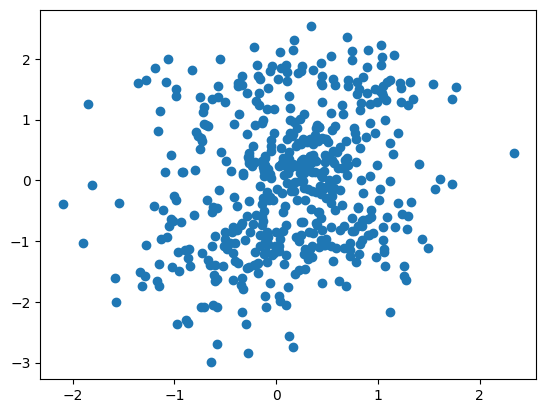

In [ ]:
### amostrar por Langevin
X = torch.randn((500, 2))
N = 1000
T = 100
t = 0*torch.ones((500, 1))
dt = T/N
for i in range(N):
  xt = torch.cat((X,t), dim = 1).to(device)
  W = torch.randn_like(X)
  X = X + model(xt).detach().cpu()/2*dt + np.sqrt(dt)*W
plt.scatter(X.detach().numpy()[:,0], X.detach().cpu().numpy()[:,1])

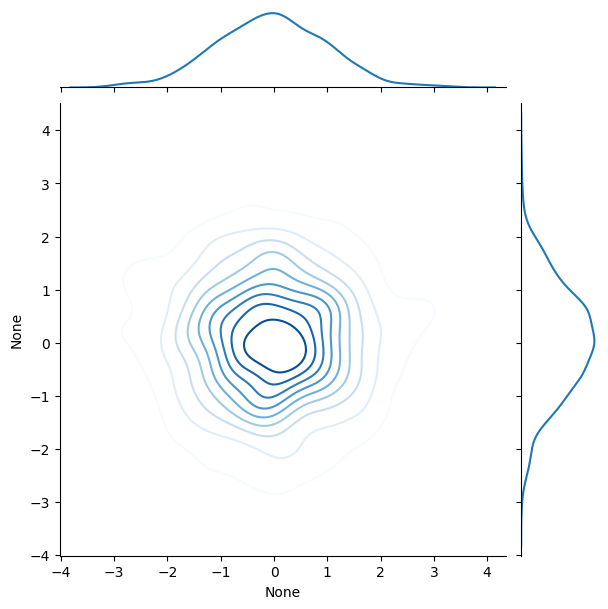

In [ ]:
### amostrar por Langevin
X = torch.randn((1000, 2)).to(device)
N = 5000
T = 500
t = torch.ones((1000, 1)).to(device)
dt = T/N
for i in range(N):
  xt = torch.cat((X,t), dim = 1).to(device)
  W = torch.randn_like(X).to(device)
  X = X + model(xt)/2*dt + np.sqrt(dt)*W
sns.jointplot(x=X.detach().cpu().numpy()[:,0], y=X.detach().cpu().numpy()[:,1], cmap="Blues", kind='kde')

In [ ]:
"""def sample(t, x0, b_min = 0.1, b_max = 20.0):
  ''''
    x_0: A matrix (d, n)
    t: A vector with size (d, 1)

    return sample of size (d,n)
  '''

  mean = x0 * torch.exp(-1/2*(t*b_min + (t**2)/2*(b_max-b_min)))
  var = 1 -  torch.exp(-(t*b_min + (t**2)/2*(b_max-b_min)))
  Z = torch.randn_like(x0)
  sample = mean + torch.sqrt(var)*Z
  return sample

def loss_fn(model, x, b_min = 0.1, b_max = 20.0, eps=1e-5, T = 1.0):
  loss = 0
  for _ in range(30):
    t = torch.rand(x.shape[0], 1, device=x.device) * (T - eps) + eps
    x_perturbed = sample(t, x, b_min = b_min, b_max = b_max)
    xt = torch.cat((x_perturbed, t), dim = 1)
    score = model(xt)
    mean = x * torch.exp(-1/2*(t*b_min + (t**2)/2*(b_max-b_min)))
    var = 1 -  torch.exp(-(t*b_min + (t**2)/2*(b_max-b_min)))
    score_match = -(x - mean) / var
    loss += torch.mean((score - score_match)**2)
  return loss"""